Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import warnings
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
warnings.filterwarnings("ignore")

In [2]:
data_dir_train = "Skin cancer ISIC The International Skin Imaging Collaboration/Train"
data_dir_test = "Skin cancer ISIC The International Skin Imaging Collaboration/Test"

In [3]:
image_count_train = len(list(pathlib.Path(data_dir_train).glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(pathlib.Path(data_dir_test).glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
                                                              seed=123, image_size=(img_height,img_width), batch_size=batch_size,
                                                              subset="training",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
                                                              seed=123, image_size=(img_height,img_width), batch_size=batch_size,
                                                              subset="validation",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

2024-05-08 20:07:06.240794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


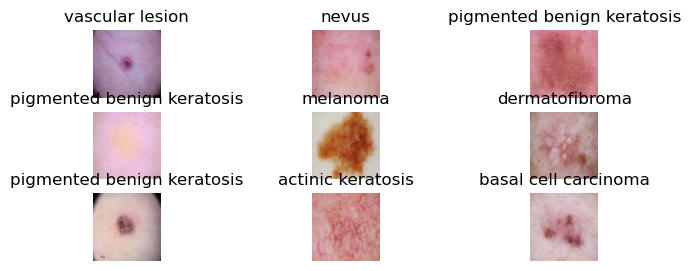

In [8]:
import matplotlib.pyplot as plt

num_classes = len(class_names)

fig = plt.figure(figsize=(8,3))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.2327 - loss: 2.0730 - val_accuracy: 0.4385 - val_loss: 1.6691
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.4445 - loss: 1.5969 - val_accuracy: 0.4855 - val_loss: 1.4998
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.4759 - loss: 1.5012 - val_accuracy: 0.4720 - val_loss: 1.5043
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.5253 - loss: 1.3820 - val_accuracy: 0.5280 - val_loss: 1.3795
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.5423 - loss: 1.3138 - val_accuracy: 0.5414 - val_loss: 1.3998
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.5796 - loss: 1.2223 - val_accuracy: 0.5190 - val_loss: 1.3905
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.5926 - loss: 1.1807 - val_accuracy: 0.5526 - val_loss: 1.3484
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.6196 - loss: 1.0878 - val_accuracy

### Visualizing training results

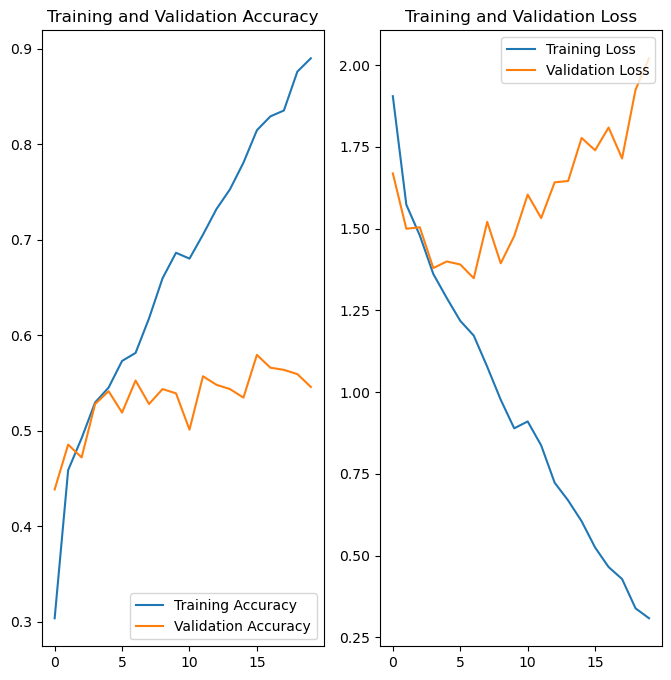

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We can see clearly that there is sign of model overfitting as the training accuracy is increasing with every epochs whereas the validation accuracy has reached max between 55%. Let's use augmentation strategy and Dropout to fix that.

#### Let us use augmentation strategy which generates additional training data from existing training data by augmenting them using random transformations 

In [17]:
augmentation_layer = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

2024-05-08 20:10:36.871882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


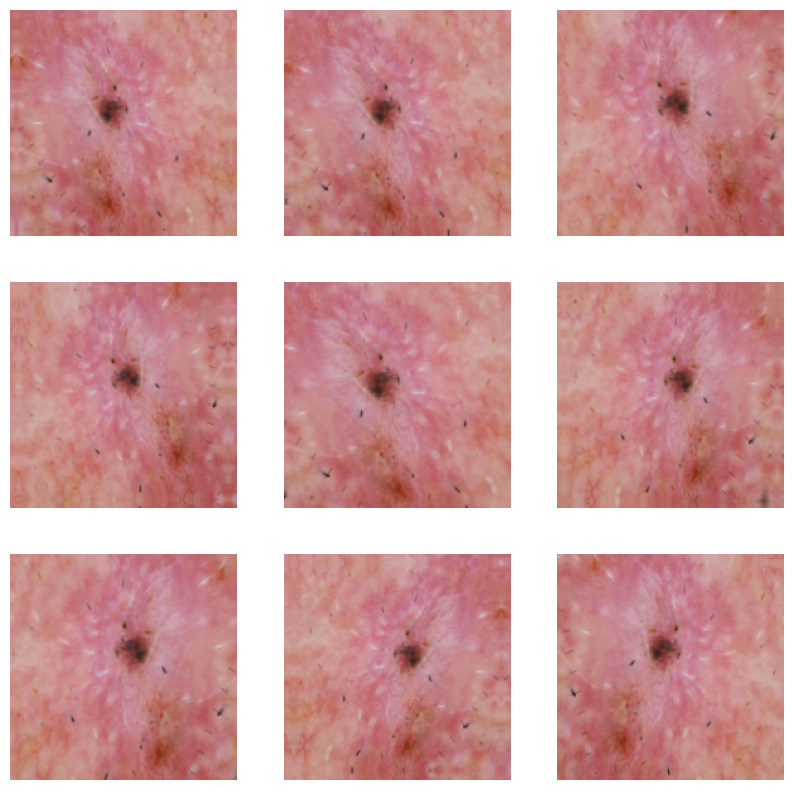

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_layer(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#### Let us build a model using the augemetation layer and adding dropouts to the model

In [19]:
model = Sequential([
  augmentation_layer,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

#### Let us compile & fit the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - accuracy: 0.1846 - loss: 2.3234 - val_accuracy: 0.2058 - val_loss: 2.0372
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - accuracy: 0.1935 - loss: 2.0742 - val_accuracy: 0.2998 - val_loss: 1.8925
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.2940 - loss: 1.9224 - val_accuracy: 0.3781 - val_loss: 1.7999
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 249s 5s/step - accuracy: 0.3190 - loss: 1.8479 - val_accuracy: 0.4072 - val_loss: 1.6944
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.3701 - loss: 1.7576 - val_accuracy: 0.4497 - val_loss: 1.6169
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.3997 - loss: 1.6579 - val_accuracy: 0.5011 - val_loss: 1.5041
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.4821 - loss: 1.5532 - val_accuracy: 0.4743 - val_loss: 1.5785
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.4646 - loss: 1.5323 - val_accura

### Visualizing the results

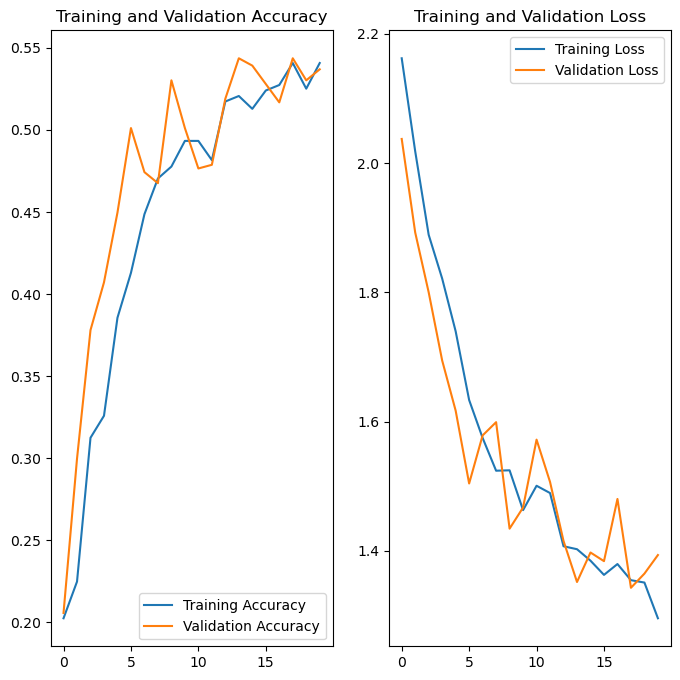

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### As we can see, the training accuracy has been decreased to 60% and validation accuracy is increased to 56%. From the graph as well we can see that both training and validation accuracy is not on almost the same range.

#### Let us find the distribution of classes in the training dataset.

In [23]:
count = np.zeros(num_classes, dtype=np.int32)
for _, labels in train_ds:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()
print("Below are the distribution of images against the class labels")
print(count)

Below are the distribution of images against the class labels
[ 92 309  77 352 277 370  58 142 115]


2024-05-08 20:18:21.850769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### We can see that there are some categories having higher number of images than others. Let's use augmentor to fix that

#### Rectify the class imbalance.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
data_dir_train=pathlib.Path(data_dir_train)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1776EB990>: 100%|█████████| 500/500 [00:02<00:00, 199.79 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x177A6C7D0>: 100%|█████████| 500/500 [00:02<00:00, 210.10 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17780FB10>: 100%|█████████| 500/500 [00:02<00:00, 201.89 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1776CA350>: 100%|█████████| 500/500 [00:13<00:00, 36.04 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16A38B550>: 100%|██████████| 500/500 [00:09<00:00, 50.59 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16A700810>: 100%|█████████| 500/500 [00:02<00:00, 201.78 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x16A7EDFD0>: 100%|█| 500/500 [00:05<00:00, 91.94 


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x177795650>: 100%|█| 500/500 [00:02<00:00, 202.10 


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1777FA0D0>: 100%|█████████| 500/500 [00:02<00:00, 197.64 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010209.jpg_4f3b6810-de21-46d4-894d-632b87889db1.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000154.jpg_1865cb65-fe11-414e-8a7a-dab060329c90.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000302.jpg_5feaa02f-e09a-4352-9e95-5e02172a6dc6.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010536.jpg_706d633a-d905-40c1-a333-8abee2b9274a.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000516.jpg_09dccff4-df93-4734-b35d-764a86bf5abc.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010796.jpg_e3046878-28f7-4231-b8d5-949947efe787.jpg',
 'Skin cancer IS

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [29]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict_new

{'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010209.jpg_4f3b6810-de21-46d4-894d-632b87889db1.jpg': 'melanoma',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000154.jpg_1865cb65-fe11-414e-8a7a-dab060329c90.jpg': 'melanoma',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000302.jpg_5feaa02f-e09a-4352-9e95-5e02172a6dc6.jpg': 'melanoma',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010536.jpg_706d633a-d905-40c1-a333-8abee2b9274a.jpg': 'melanoma',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000516.jpg_09dccff4-df93-4734-b35d-764a86bf5abc.jpg': 'melanoma',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010796.jpg

In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2['Label'].value_counts()

Label
melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [31]:
batch_size = 32
img_height = 180
img_width = 180

In [32]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
seed=123, 
image_size=(img_height,img_width), 
batch_size=batch_size,
subset="training",
validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
seed=123, 
image_size=(img_height,img_width), 
batch_size=batch_size,
subset="validation",
validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Rebuild the model with same parameters that were used to build before

In [34]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

#### Compile the model

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [36]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 206ms/step - accuracy: 0.1984 - loss: 2.1544 - val_accuracy: 0.3957 - val_loss: 1.5757
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 221ms/step - accuracy: 0.3613 - loss: 1.6639 - val_accuracy: 0.4581 - val_loss: 1.4625
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 229ms/step - accuracy: 0.4294 - loss: 1.5126 - val_accuracy: 0.5174 - val_loss: 1.2861
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 231ms/step - accuracy: 0.4583 - loss: 1.4077 - val_accuracy: 0.5449 - val_loss: 1.2095
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 244ms/step - accuracy: 0.5088 - loss: 1.2878 - val_accuracy: 0.5828 - val_loss: 1.1383
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 260ms/step - accuracy: 0.5278 - loss: 1.2421 - val_accuracy: 0.5679 - val_loss: 1.1227
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 271ms/step - accuracy: 0.5611 - loss: 1.1355 - val_accuracy: 0.5887 - val_loss: 1.0363
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 286ms/step - accuracy: 0.5919 - loss: 1

169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 295ms/step - accuracy: 0.9098 - loss: 0.2229 - val_accuracy: 0.8374 - val_loss: 0.7162


#### Visualize the model results

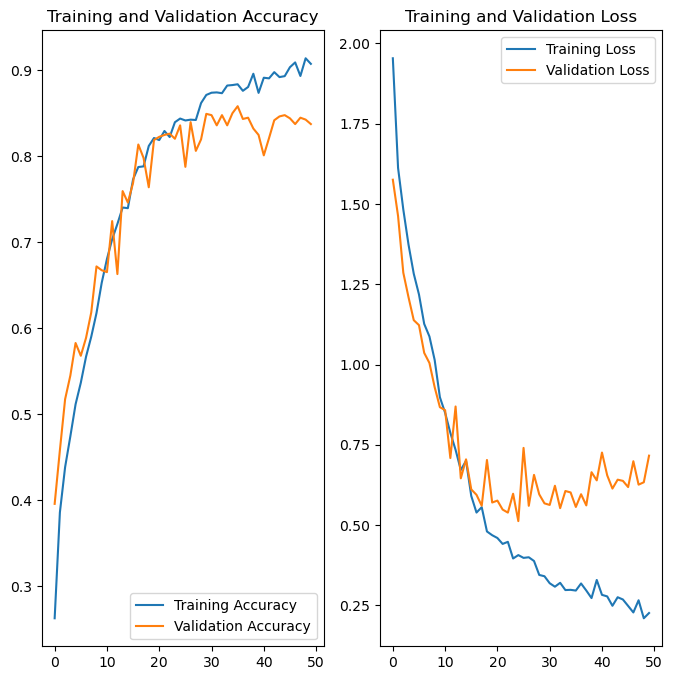

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### As we can see clearly, after using augmentor for class imbalancing, the training accuracy has reached 90% and validation accuracy has reached upto 83% which is a significant improvement in the model's performance